<a href="https://colab.research.google.com/github/JonasBiermann/JonasBiermann/blob/main/fcc_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [17]:
dataset_cols = ['bike_count', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']
df = pd.read_csv('SeoulBikeData.csv', encoding = "ISO-8859-1").drop(['Date', 'Holiday', 'Seasons'], axis=1)

In [22]:
df.columns = dataset_cols
df['functional'] = (df['functional'] == 'Yes').astype(int)
df = df[df['hour'] ==12]
df = df.drop(['hour'], axis = 1)

In [23]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


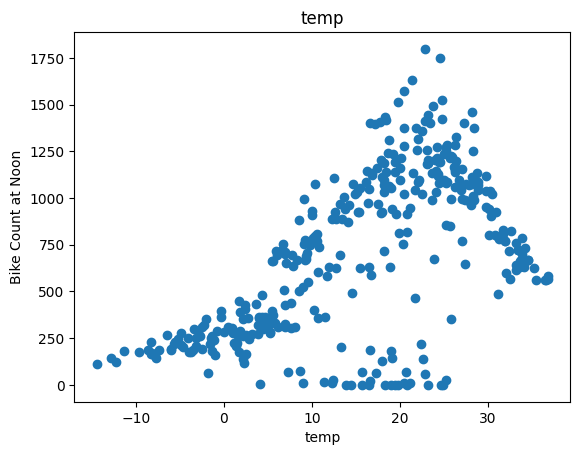

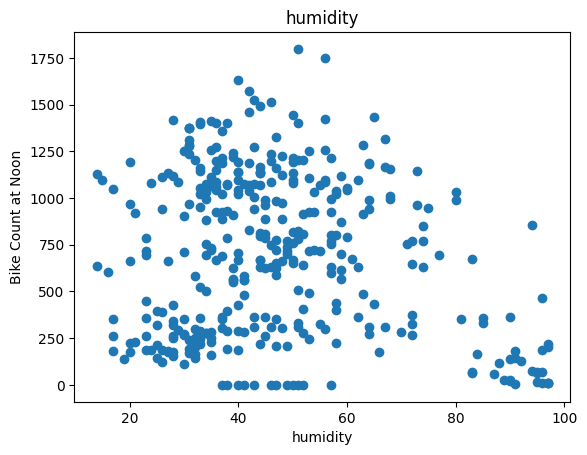

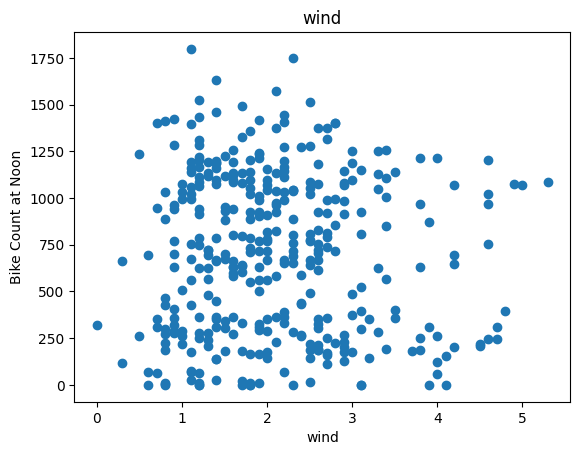

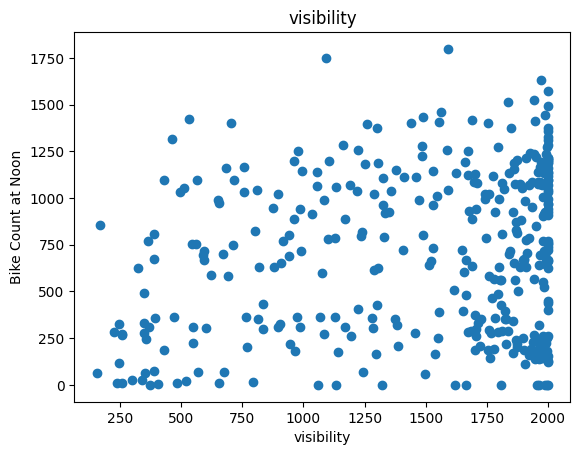

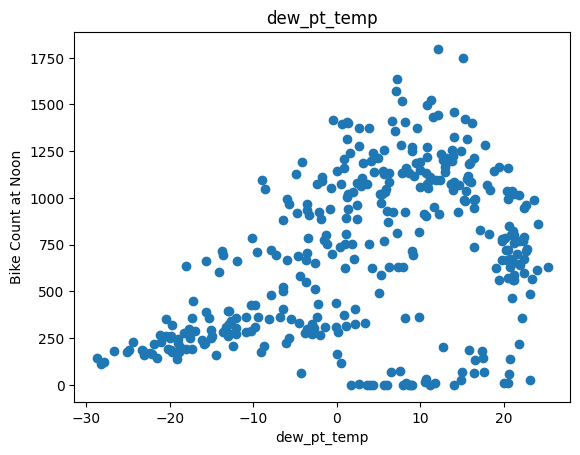

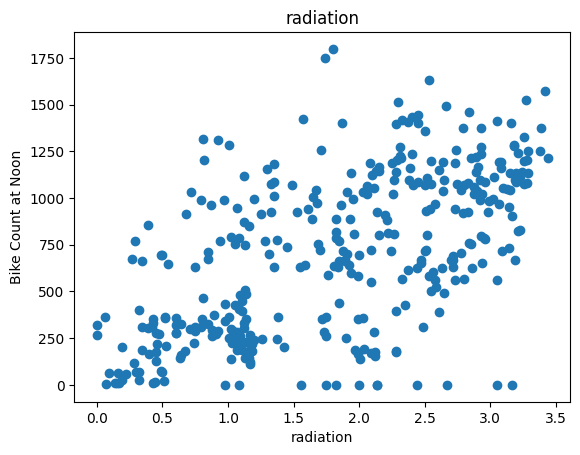

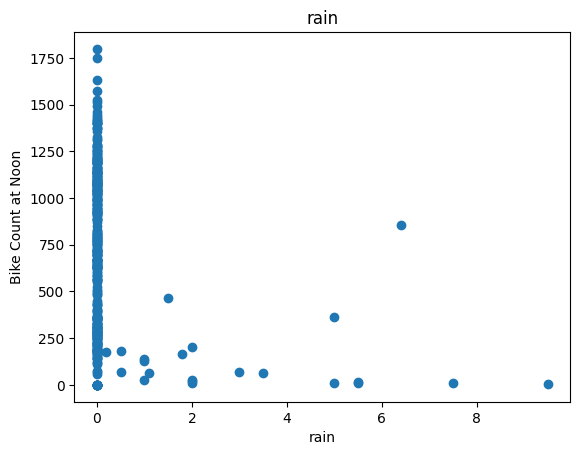

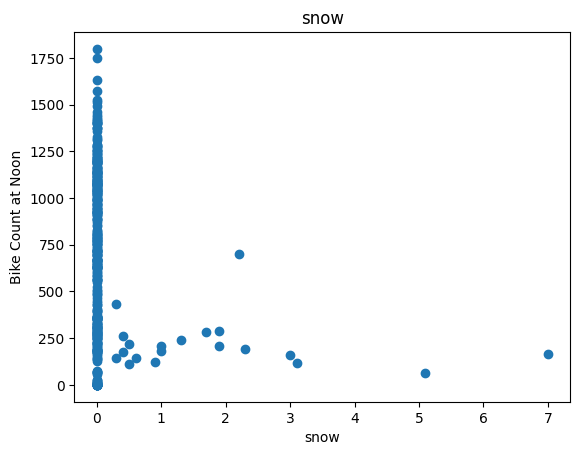

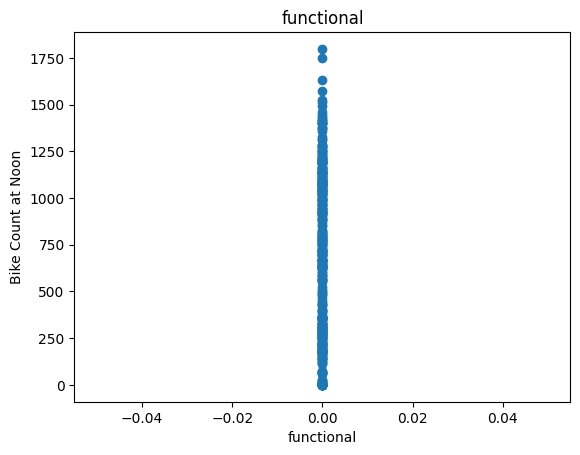

In [24]:
for label in df.columns[1:]:
  plt.scatter(df[label], df['bike_count'])
  plt.title(label)
  plt.ylabel('Bike Count at Noon')
  plt.xlabel(label)
  plt.show()

we're going to drop the columns that don't seem to make a big impact on the data

In [25]:
df = df.drop(['wind', 'visibility', 'functional'], axis = 1)

In [26]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/valid/test dataset

In [27]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [39]:
def get_xy(dataframe, y_label, x_labels = None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((x, y))

  return data, x, y

# Linear Regression

In [45]:
_, x_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, x_valid_temp, y_valid_temp = get_xy(valid, 'bike_count', x_labels=['temp'])
_, x_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [46]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [47]:
temp_reg.score(x_test_temp, y_test_temp)

0.32872765345131094

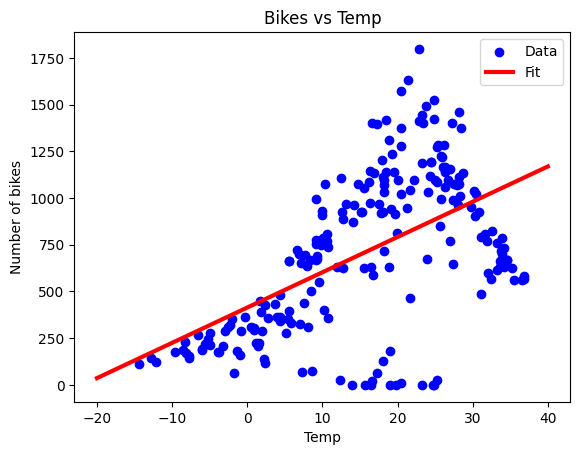

In [48]:
plt.scatter(x_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Linear Regression

In [49]:
_, x_train, y_train = get_xy(train, 'bike_count', x_labels=df.columns[1:])
_, x_valid, y_valid = get_xy(valid, 'bike_count', x_labels=df.columns[1:])
_, x_test, y_test = get_xy(test, 'bike_count', x_labels=df.columns[1:])

In [50]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [51]:
reg.score(x_test, y_test)

0.41919441232137067

# Regression with Neural Net (using Tensorflow)

In [52]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1, ), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [54]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [56]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [57]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1),
    y_train_temp,
    verbose = 0,
    epochs=1000,
    validation_data=(x_valid_temp, y_valid_temp)
)

In [58]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

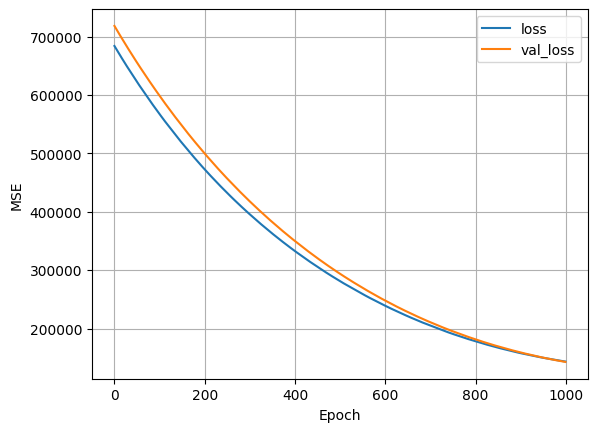

In [59]:
plot_loss(history)

4/4 [==============================] - 0s 5ms/step


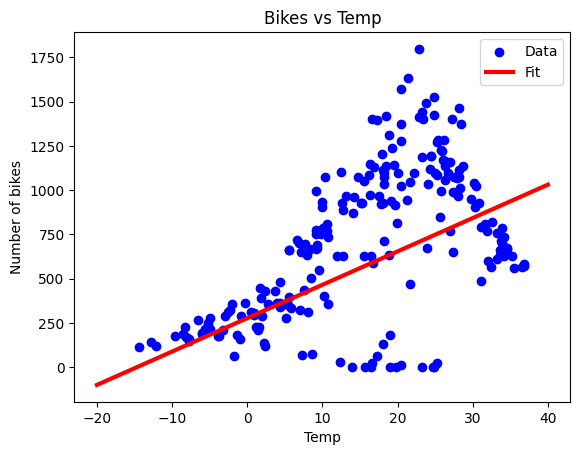

In [60]:
plt.scatter(x_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Linear Regressions with Neural Net (using Tensorflow)

In [106]:
normalizer = tf.keras.layers.Normalization(input_shape=(6, 1), axis=-1)
normalizer.adapt(x_train)

In [107]:
nn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])

In [108]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_loss')

4/4 [==============================] - 0s 3ms/step


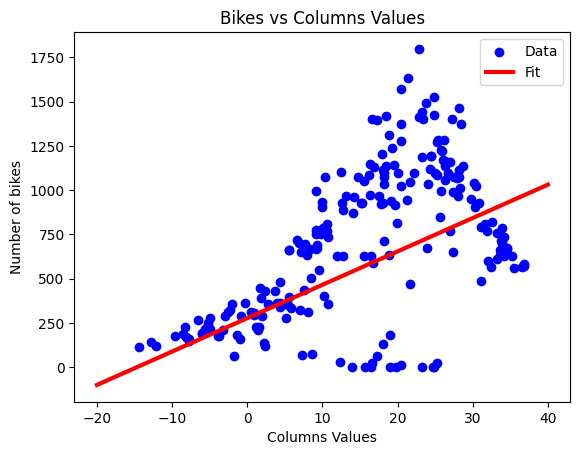

In [111]:
plt.scatter(x_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Columns Values')
plt.ylabel('Number of bikes')
plt.xlabel('Columns Values')
plt.show()

# Neural Net

In [112]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [113]:
history = nn_model.fit(
    x_train_temp,
    y_train_temp,
    validation_data=(x_valid_temp, y_valid_temp),
    verbose=0,
    epochs=100
)

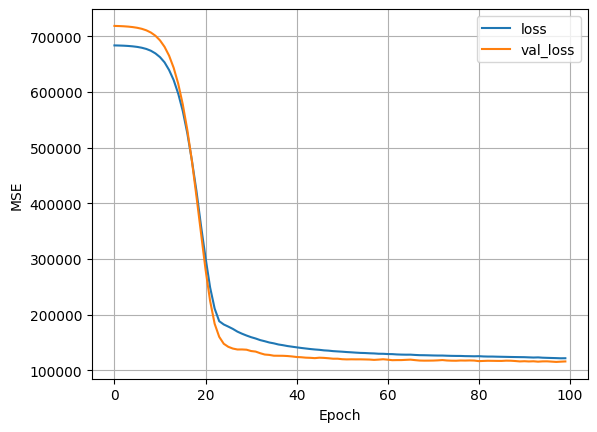

In [114]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


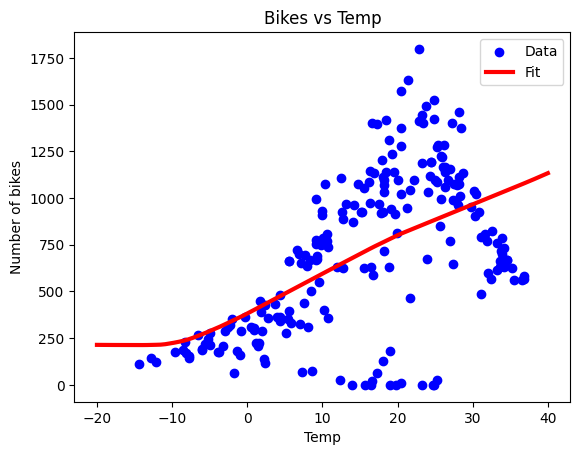

In [115]:
plt.scatter(x_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

# Neural Net Multiple Regressions

In [130]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train)

In [131]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [132]:
history = nn_model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    verbose = 0,
    epochs=100
)

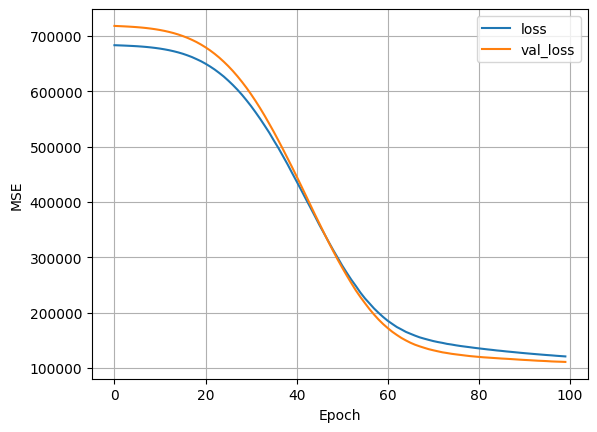

In [133]:
plot_loss(history)

In [134]:
# calculate the MSE for both linear reg and nn

y_pred_lr = reg.predict(x_test)
y_pred_nn = nn_model.predict(x_test)

3/3 [==============================] - 0s 4ms/step


In [135]:
def MSE(y_pred, y_real):
  return (np.square(y_pred-y_real)).mean()

In [136]:
MSE(y_pred_lr, y_test)

113373.01791307915

In [137]:
MSE(y_pred_nn, y_test)

104348.2642321219

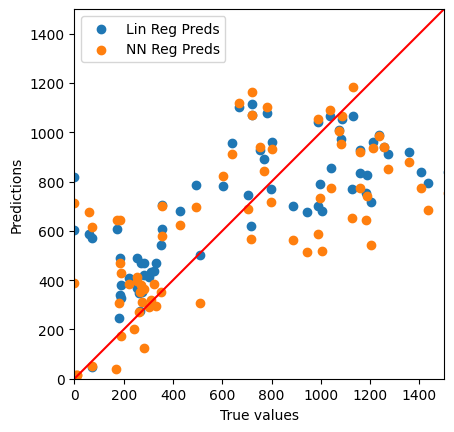

In [143]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_lr, label='Lin Reg Preds')
plt.scatter(y_test, y_pred_nn, label='NN Reg Preds')
plt.xlabel('True values')
plt.ylabel('Predictions')
limg = [0, 1500]
plt.xlim(limg)
plt.ylim(limg)
plt.legend()
_ = plt.plot(limg, limg, c='red')